# DeFi Derivative Dynamic Simulation

This notebook complements the formal framework presented in the paper *Systematizing DeFi Derivatives Protocols: A Comparative Analysis and Conceptual Framework*.

The user can modify all parameters related to the trading position, including expectations about the underlying asset's volatility and expected return.

The goal is to provide a simple yet effective tool for understanding the key features of perpetual contracts and the general dynamics of leveraged positions.

The simulations assume an underlying asset $U$ following a geometric Brownian motion:

$$
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t
$$

where $\mu$ is the drift, $\sigma$ is the volatility, and $W_t$ is a Wiener process. Each position is opened at $t = 0$ with a predefined entry or strike price and is monitored over a finite time horizon $T$, discretized into $N$ time steps.

For each simulation, we compute:

* unrealized and realized PnL over time;
* cumulative funding and borrowing fees;
* equity evolution and potential liquidation events.


## Perpetuals Tuple Definition

Each Perpetuals position is defined by the tuple **(U, C, L, S, Pe)**, where:

- **U**: Underlying asset  
- **C**: Collateral  
- **L**: Leverage  
- **S**: Strategy  
- **Pe**: Entry price of the position

## Assumed Fees

We assume the following fee structure, which can be modified by the user to reflect the characteristics of a specific protocol:

- **F_open**: Fee for opening the position  
- **F_close**: Fee for closing the position  
- **F_borrow**: Fee for borrowing liquidity  
- **F_funding**: Ongoing funding fee (e.g., hourly, based on position size and liquidity pool dynamics)  
- **F_other**: Additional fees related to protocol-specific mechanics, such as price impact, slippage, etc.


## Coding Section

**Libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Definition of the Simulation**

In [4]:
def simulate_perpetual_pnl(
        S0=100 # Initial price of the underlying asset
        ,mu=0.05 # Expected return of the underlying asset
        ,sigma=0.3 # Volatility of the underlying asset
        ,T=10    #Time horizon in days
        ,dt=1/24    #Time step in days (1 hour)
        ,entry_price=100 #Entry price of the position 
        ,leverage=5  #Leverage used by the trader
        ,collateral=1000 #Collateral used by the trader
        ,funding_coef=0.001  # Funding coefficient (0.001% per hour)
        ,maintenance_margin_rate=0.1 # Maintenance margin rate (10% of the position size)
        ,trading_fee_rate=0.0006     # Trading fee rate (0.06% per trade)
        ,borrow_fee_rate=0.0001  # Borrow fee rate (0.01% per hour)
        ,other_fee=0  # Other fees (e.g., exchange fees) applied only at opening
        ,is_long=True  # True for long position, False for short position
        ,apply_funding_fee=True  # Whether to apply funding fee (True by default)
    ):

    if any(x <= 0 for x in [S0, leverage, collateral, dt, T]):
        raise ValueError("S0, leverage, collateral, dt, and T must be positive.")
    
    N = int(T/dt)
    time_grid = np.linspace(0, T, N)


    dW = np.random.normal(0, np.sqrt(dt), N)
    noise = np.random.normal(0, 0.001, N)

    S = [S0]
    for i in range(1, N):
        St = S[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW[i])
        S.append(St)
    S = np.array(S)

    perp_price = S * (1 + noise)
    #funding_rate = funding_coef * (perp_price - S) / S
    funding_rate = funding_coef * (perp_price - S) / S if apply_funding_fee else np.zeros(N)

    NV = collateral * leverage
    Mm = maintenance_margin_rate * NV
    position_size = NV / entry_price

    trading_fees = NV * trading_fee_rate * 2  # apertura + chiusura
    extra_opening_fee = NV * other_fee       # applicata solo all'apertura
    borrow_fees = NV * borrow_fee_rate * dt * N

    direction = 1 if is_long else -1

    pnl_list, funding_list, equity_list, liquidation_flag, borrow_fee_list = [], [], [], [], []
    cum_funding = 0
    cum_borrow_fee = 0

    for t in range(N):
        spot_t = S[t]
        price_diff = spot_t - entry_price
        pnl = direction * position_size * price_diff
        funding_payment = position_size * perp_price[t] * funding_rate[t] * dt if apply_funding_fee else 0
        borrow_payment = NV * borrow_fee_rate * dt  # Borrow fee applicato ogni ora
        cum_funding += funding_payment
        cum_borrow_fee += borrow_payment
        equity = collateral + pnl - cum_funding - cum_borrow_fee
        liquidated = equity < Mm

        pnl_list.append(pnl)
        funding_list.append(cum_funding)
        equity_list.append(equity)
        liquidation_flag.append(liquidated)
        borrow_fee_list.append(cum_borrow_fee)

        if liquidated:
            break

    realized_pnl = pnl_list[-1] - cum_funding - trading_fees - borrow_fees - extra_opening_fee
    no_profit = realized_pnl <= 0

    return {
        "final_equity": equity_list[-1],
        "final_pnl": realized_pnl,
        "liquidated": any(liquidation_flag),
        "no_profit": no_profit,
        "equity_path": equity_list,
        "time_path": time_grid[:len(equity_list)],
        "pnl_path": pnl_list[:len(equity_list)],
        "spot_path": S[:len(equity_list)],
        "perp_price_path": perp_price[:len(equity_list)],
        "borrow_fee_path": borrow_fee_list[:len(equity_list)],
        "cum_funding":      cum_funding,               # total $ paid/received
        "cum_borrow_fee":   cum_borrow_fee,            # total $ borrow cost
        "funding_path":     funding_list[:len(equity_list)],
        "total_trading_fees": trading_fees + extra_opening_fee,
    }


**Batch Simulation for Pepetuals**

In [5]:
def batch_simulate_perpetuals(n_runs=1000, **kwargs):
    results = [simulate_perpetual_pnl(**kwargs) for _ in range(n_runs)]

    final_pnls = [r['final_pnl'] for r in results]
    liquidations = [r['liquidated'] for r in results]
    no_profits = [r['no_profit'] for r in results]

    print(f"Number of simulations: {n_runs}")
    print(f"Average PnL: {np.mean(final_pnls):.2f}")
    print(f"Liquidation probability: {np.mean(liquidations)*100:.1f}%")

    sns.histplot(final_pnls, kde=True, bins=50, color='skyblue')
    plt.title('Distribution of Realized PnL from multiple simulations')
    plt.xlabel('PnL')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    is_long = kwargs.get("is_long", True)
    strategy_label = "Long" if is_long else "Short"

    plt.figure(figsize=(10, 6))
    for r in results[:100]:
        if r['liquidated']:
            color = 'red'
        elif r['no_profit']:
            color = 'orange'
        else:
            color = 'green'
        plt.plot(r['time_path'], r['pnl_path'], alpha=0.3, linewidth=0.8, color=color)
    plt.title(f'PnL Evolution over Time ({strategy_label} Strategy, Sample of 100)')
    plt.xlabel('Time (days)')
    plt.ylabel('PnL')
    plt.grid(True)
    plt.show()




In [ ]:
#Example Usage of Perpetual Simulation with Random Data
#batch_simulate_perpetuals(
#    n_runs=10000,
#    S0=100, mu=0.05, sigma=0.3, T=5, dt=1/24,
#    entry_price=100, leverage=5, collateral=1000,
#    funding_coef=0.001, maintenance_margin_rate=0.1,
#    trading_fee_rate=0.0006, borrow_fee_rate=0.0001, is_long=True
#)

**Simulation of a Long Position on Solana on Jupiter Exchange at 6/26/25 at 11.00**

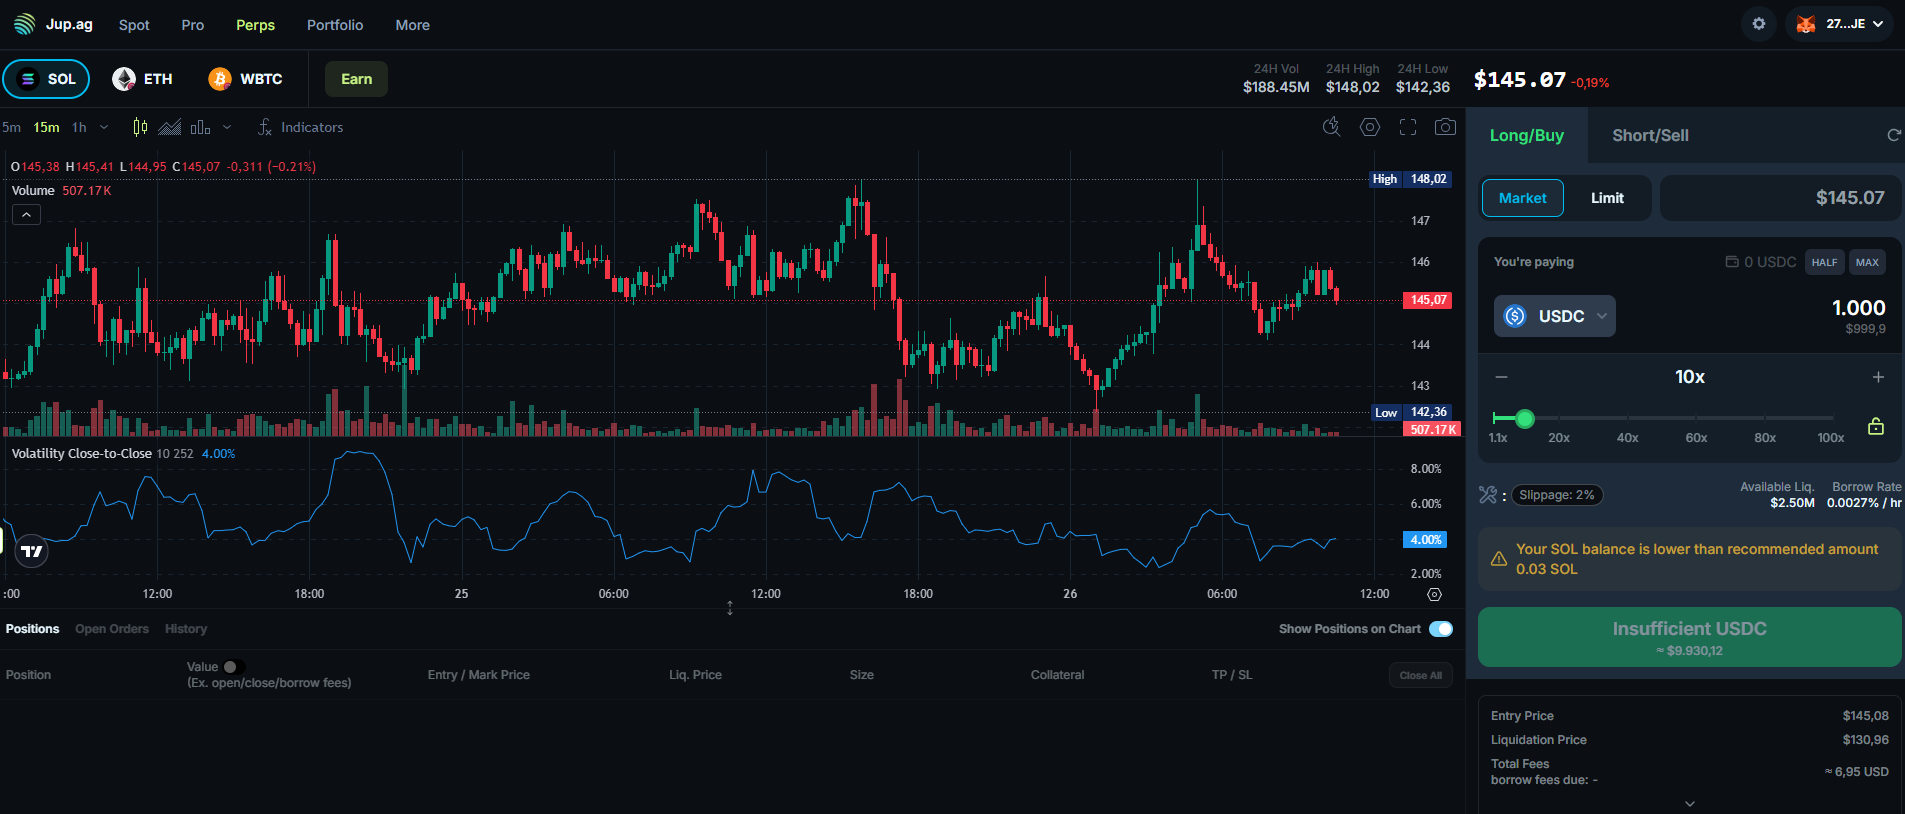

Number of simulations: 10000
Average PnL: -7.94
Liquidation probability: 32.5%


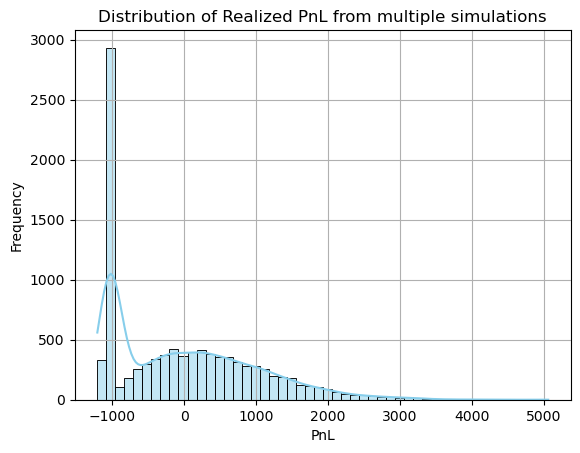

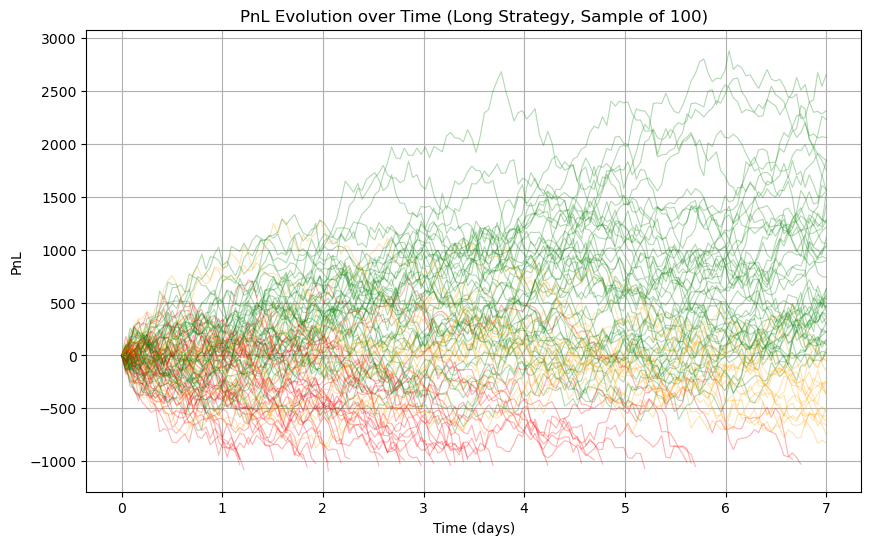

In [7]:
# Jupiter simulation example
batch_simulate_perpetuals(
    n_runs=10000,
    S0=145.51, 
    mu=0.0,
    sigma=0.04, 
    T=7,
    dt=1/24,
    entry_price=145.51, 
    leverage=10, 
    collateral=1000, #1000 USDC
    funding_coef=0, #incorporate also borrow fees
    maintenance_margin_rate=0.002556,
    trading_fee_rate=0.0006, 
    borrow_fee_rate=0.000027, 
    other_fee=0.0002,  # Price impact fee 2% onlywhen you open the position
    is_long=True,
    apply_funding_fee=False  # No funding fee for this simulation
)

**Simulation of a Long Position on Solana on dYdX at 6/26/25 at 12.44** 

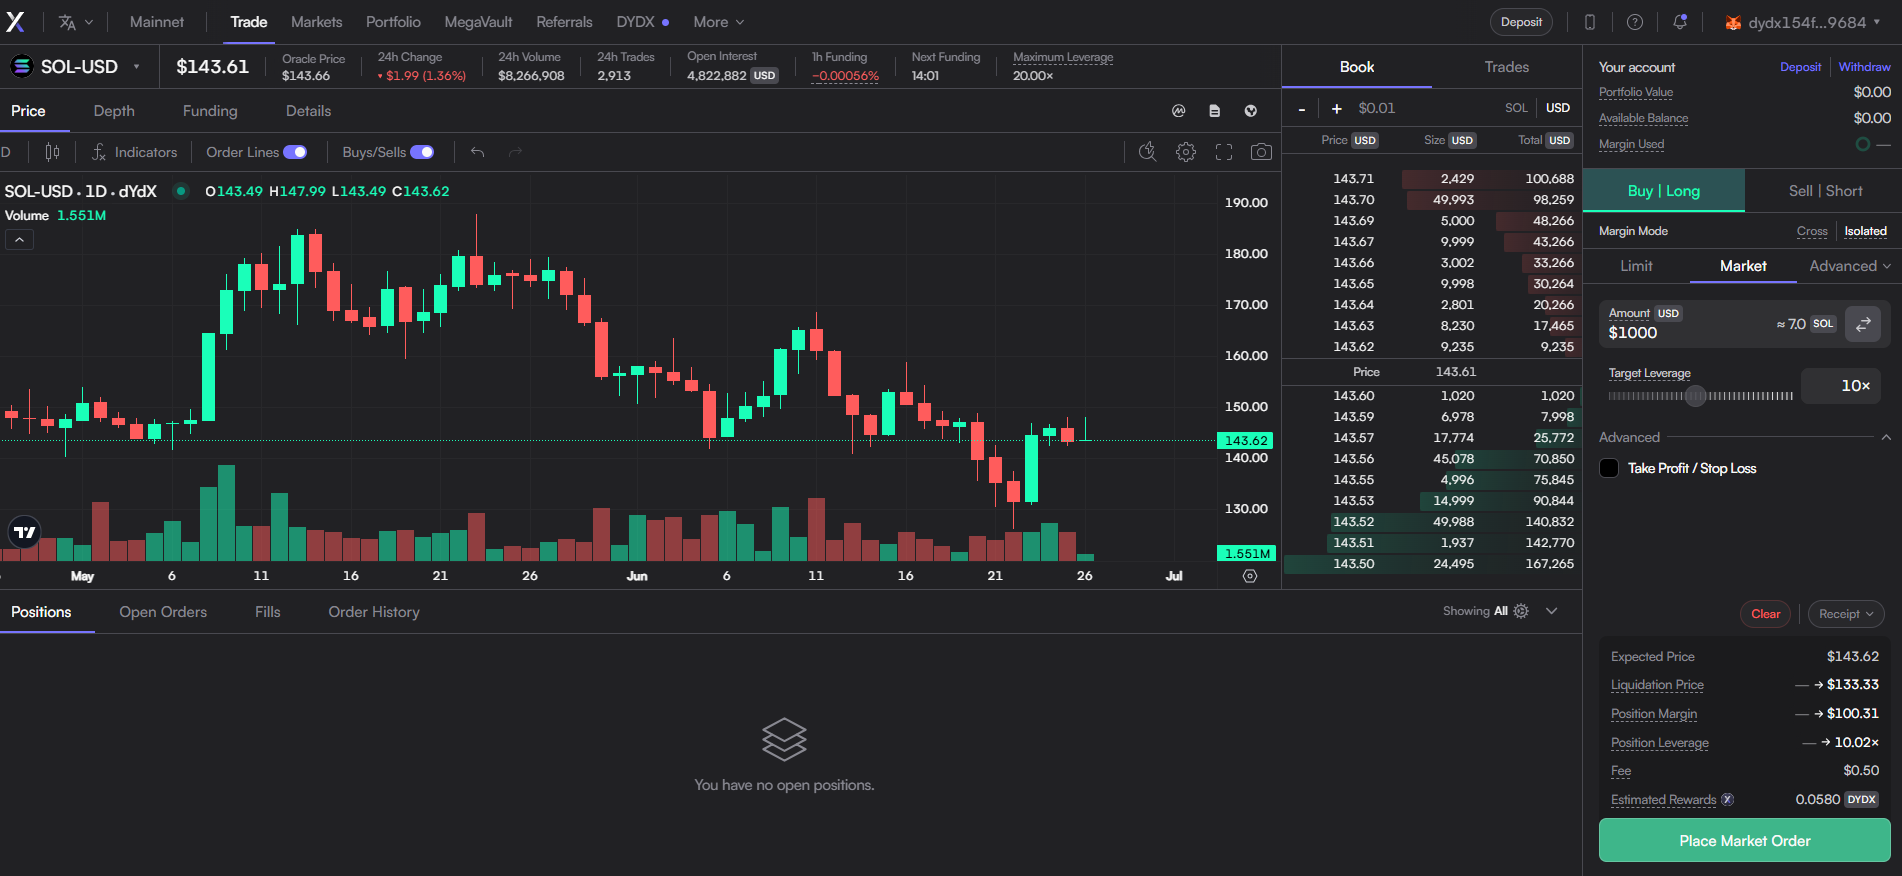

Number of simulations: 10000
Average PnL: 5.38
Liquidation probability: 91.2%


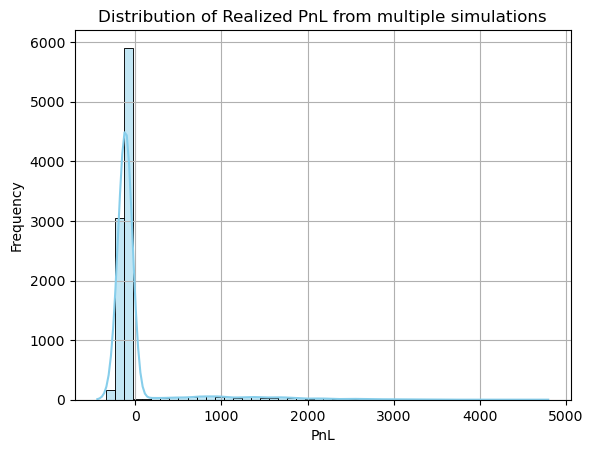

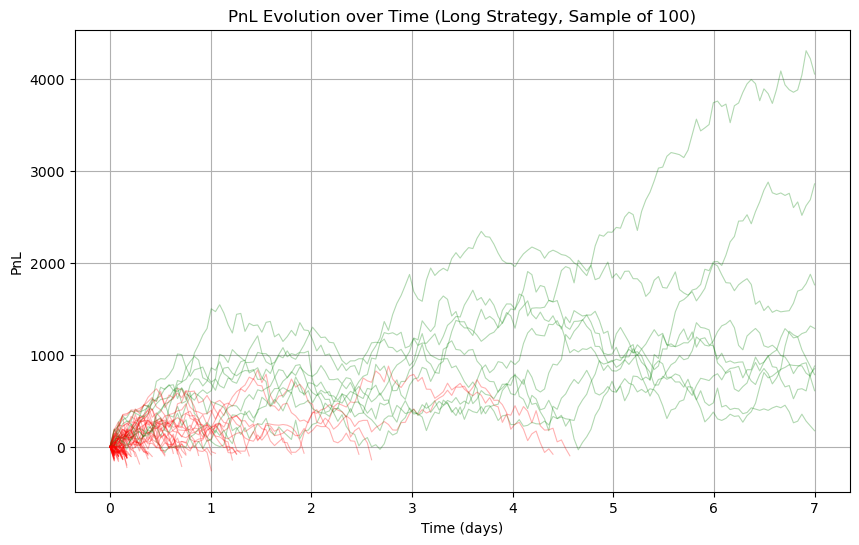

In [8]:
# Jupiter simulation example
batch_simulate_perpetuals(
    n_runs=10000,
    S0=143.62, 
    mu=0.0,
    sigma=0.04, 
    T=7, #one day
    dt=1/24,
    entry_price=143.62, 
    leverage=10.02, 
    collateral=1000, #1000 USDC
    funding_coef=0.00056, #incorporate also borrow fees
    maintenance_margin_rate=0.0927,
    trading_fee_rate=0.00006, 
    borrow_fee_rate=0, 
    other_fee=0,  # Price impact fee 2% onlywhen you open the position
    is_long=True,
    apply_funding_fee=True  # No funding fee for this simulation
)



## Everlasting Option Tuple Definition

Each Everlasting position is defined by the tuple **(U, C, L, S, Ps)**, where:

- **U**: Underlying asset  
- **C**: Collateral  
- **L**: Leverage  
- **S**: Strategy  
- **Ps**: Strike price of the option

## Assumed Fees

We assume the following fee structure, which can be modified by the user to reflect the characteristics of a specific protocol:

- **F_open**: Fee for opening the position  
- **F_close**: Fee for closing the position  
- **F_borrow**: Fee for borrowing liquidity  
- **F_funding**: Ongoing funding fee (e.g., hourly, based on position size and liquidity pool dynamics)  
- **F_other**: Additional fees related to protocol-specific mechanics, such as price impact, slippage, etc.


In [9]:
def simulate_everlasting_option_pnl(
    S0=100,
    mu=0.05,
    sigma=0.3,
    T=10,
    dt=1/24,
    strike_price=100,
    leverage=5,
    collateral=1000,
    maintenance_margin_rate=0.1,
    trading_fee_rate=0.0006,
    borrow_fee_rate=0.0001,
    other_fee=0,
    is_long=True,
    apply_funding_fee=True,
    option_type='call'
):
    import numpy as np

    if any(x <= 0 for x in [S0, leverage, collateral, dt, T]):
        raise ValueError("S0, leverage, collateral, dt, and T must be positive.")
    
    N = int(T / dt)
    time_grid = np.linspace(0, T, N)
    dW = np.random.normal(0, np.sqrt(dt), N)
    noise = np.random.normal(0, 0.001, N)

    S = [S0]
    for i in range(1, N):
        St = S[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW[i])
        S.append(St)
    S = np.array(S)

    option_payoff = np.maximum(S - strike_price, 0) if option_type == 'call' else np.maximum(strike_price - S, 0)
    mark_price = option_payoff * (1 + noise) + 1e-6

    # Funding fee oraria SENZA clip e SENZA threshold
    funding_fee_per_hour = (mark_price - option_payoff) / (7 * 24)

    NV = collateral * leverage
    Mm = maintenance_margin_rate * NV
    trading_fees = NV * trading_fee_rate * 2
    extra_opening_fee = NV * other_fee
    borrow_fees = NV * borrow_fee_rate * dt * N

    direction = 1 if is_long else -1
    pnl_list, funding_list, equity_list, liquidation_flag, borrow_fee_list = [], [], [], [], []
    cum_funding = 0
    cum_borrow_fee = 0
    liquidated = False
    entry_payoff = option_payoff[0]

    for t in range(N):
        payoff = option_payoff[t]
        pnl = direction * (payoff - entry_payoff)
        funding_payment = NV * funding_fee_per_hour[t] * dt if apply_funding_fee else 0
        borrow_payment = NV * borrow_fee_rate * dt
        cum_funding += funding_payment
        cum_borrow_fee += borrow_payment
        equity = collateral + pnl - cum_funding - cum_borrow_fee
        liquidated = equity < Mm

        pnl_list.append(pnl)
        funding_list.append(cum_funding)
        equity_list.append(equity)
        liquidation_flag.append(liquidated)
        borrow_fee_list.append(cum_borrow_fee)

        if liquidated:
            break

    if liquidated:
        realized_pnl = -collateral - trading_fees - extra_opening_fee
    else:
        realized_pnl = pnl_list[-1] - cum_funding - trading_fees - borrow_fees - extra_opening_fee

    no_profit = realized_pnl <= 0

    return {
        "final_equity": equity_list[-1],
        "final_pnl": realized_pnl,
        "max_drawdown": min(equity_list),
        "liquidated": any(liquidation_flag),
        "no_profit": no_profit,
        "equity_path": equity_list,
        "time_path": time_grid[:len(equity_list)],
        "pnl_path": pnl_list[:len(equity_list)],
        "spot_path": S[:len(equity_list)],
        "option_price_path": mark_price[:len(equity_list)],
        "borrow_fee_path": borrow_fee_list[:len(equity_list)],
        "funding_path": funding_list[:len(equity_list)]
    }


In [10]:
def batch_simulate_everlasting_options(n_runs=1000, **kwargs):
    results = [simulate_everlasting_option_pnl(**kwargs) for _ in range(n_runs)]

    final_pnls = np.array([r['final_pnl'] for r in results])
    liquidations = [r['liquidated'] for r in results]
    no_profits = [r['no_profit'] for r in results]
    max_drawdowns = [r['max_drawdown'] for r in results]

    lower_bound = np.percentile(final_pnls, 5)
    upper_bound = np.percentile(final_pnls, 95)
    trimmed_pnls = final_pnls[(final_pnls >= lower_bound) & (final_pnls <= upper_bound)]
    trimmed_mean_pnl = np.mean(trimmed_pnls)
    median_pnl = np.median(final_pnls)
    mean_pnl = np.mean(final_pnls)

    print(f"Number of simulations: {n_runs}")
    print(f"Trimmed Mean PnL (5%-95%): {trimmed_mean_pnl:.2f}")
    print(f"Median PnL: {median_pnl:.2f}")
    print(f"Mean PnL: {mean_pnl:.2f}")
    print(f"Liquidation probability: {np.mean(liquidations) * 100:.1f}%")

    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.histplot(final_pnls, kde=True, bins=50, color='lightblue')
    plt.title('Distribution of Realized PnL from Everlasting Options Simulations')
    plt.xlabel('PnL')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    is_long = kwargs.get("is_long", True)
    option_type = kwargs.get("option_type", "call")
    strategy_label = f"{'Long' if is_long else 'Short'} {option_type.capitalize()}"

    plt.figure(figsize=(10, 6))
    for r in results[:100]:
        if r['liquidated']:
            color = 'red'
        elif r['no_profit']:
            color = 'orange'
        else:
            color = 'green'
        plt.plot(r['time_path'], r['pnl_path'], alpha=0.3, linewidth=0.8, color=color)
    plt.title(f'PnL Evolution over Time ({strategy_label} Strategy, Sample of 100)')
    plt.xlabel('Time (days)')
    plt.ylabel('PnL')
    plt.grid(True)
    plt.show()


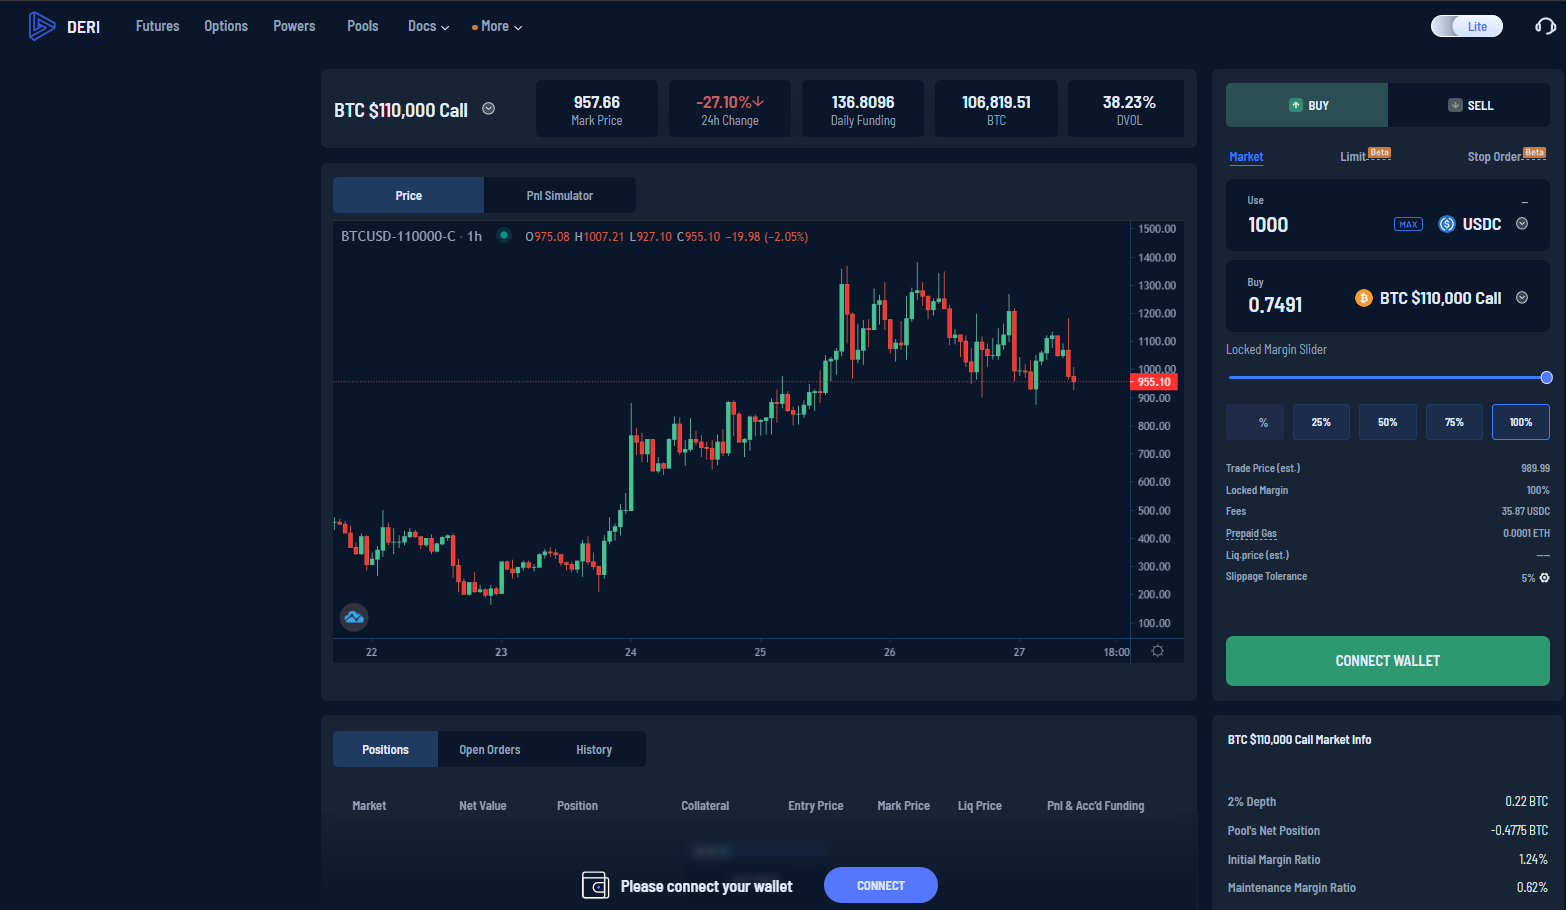

Number of simulations: 1000
Trimmed Mean PnL (5%-95%): 11118.91
Median PnL: -57.50
Mean PnL: 25423.90
Liquidation probability: 30.2%


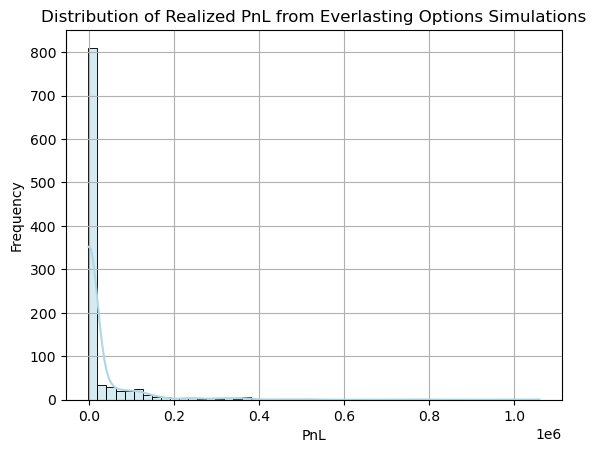

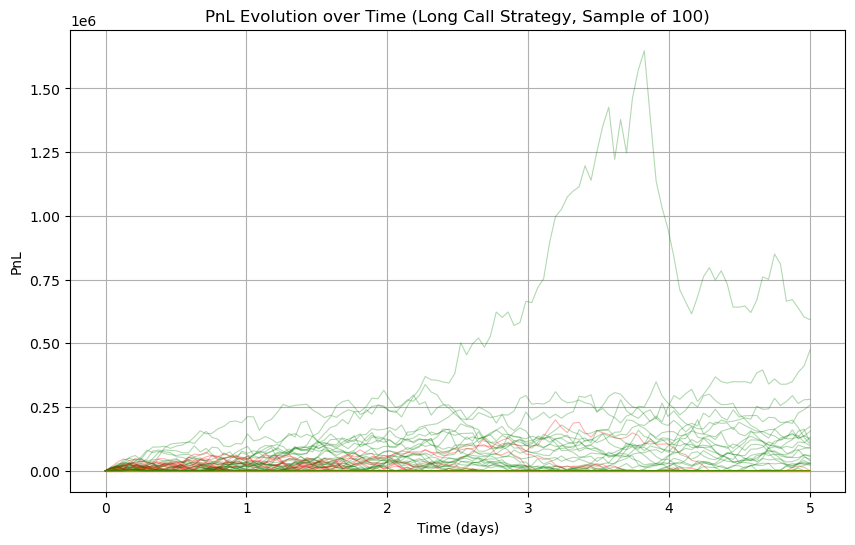

In [11]:
batch_simulate_everlasting_options(
    n_runs=1000,
    S0=106819.51,
    mu=0.0,
    sigma=0.38,
    T=5,
    dt=1/24,
    strike_price=110000,
    leverage=80.6,
    collateral=1000,
    maintenance_margin_rate=0.0062,
    trading_fee_rate=35.67 / 100000,
    borrow_fee_rate=0.0,
    other_fee=0.0,
    is_long=True,
    option_type='call'
)


## Synthetic Tuple Definition

Each Everlasting position is defined by the tuple **(U, C, L, S, Ps)**, where:

- **U**: Underlying asset  
- **C**: Collateral    
- **Pu**: Underlying Price
- **Pc**: Price Collateral

## Assumed Fees

We assume the following fee structure, which can be modified by the user to reflect the characteristics of a specific protocol:

- **F_open**: Fee for opening the position  
- **F_close**: Fee for closing the position  
- **F_borrow**: Fee for borrowing liquidity  
- **F_funding**: Ongoing funding fee (e.g., hourly, based on position size and liquidity pool dynamics)  
- **F_other**: Additional fees related to protocol-specific mechanics, such as price impact, slippage, etc.


In [12]:
def simulate_synthetic_asset_pnl(
    P_U0=100,
    P_C0=1.0,
    mu_U=0.05,
    sigma_U=0.2,
    mu_C=0.00,
    sigma_C=0.01,
    T=10,
    dt=1/24,
    collateral_amount=150.0,
    cr_min=1.3
):
    if any(x <= 0 for x in [P_U0, P_C0, collateral_amount, T, dt]):
        raise ValueError("All inputs must be positive.")

    N = int(T / dt)
    time_grid = np.linspace(0, T, N)
    dW_U = np.random.normal(0, np.sqrt(dt), N)
    dW_C = np.random.normal(0, np.sqrt(dt), N)

    P_U = [P_U0]
    P_C = [P_C0]

    for i in range(1, N):
        new_PU = P_U[-1] * np.exp((mu_U - 0.5 * sigma_U**2) * dt + sigma_U * dW_U[i])
        new_PC = P_C[-1] * np.exp((mu_C - 0.5 * sigma_C**2) * dt + sigma_C * dW_C[i])
        P_U.append(new_PU)
        P_C.append(new_PC)

    P_U = np.array(P_U)
    P_C = np.array(P_C)

    NV_synth = (collateral_amount * P_C) / P_U
    CR = (collateral_amount * P_C) / NV_synth
    liquidation_flag = CR < cr_min
    Q = NV_synth[0]  # quantità iniziale sintetica
    pnl = Q * (P_U - P_U[0])

    equity_path = pnl.copy()
    equity_path[liquidation_flag] = np.nan  # azzera equity dopo liquidazione

    final_equity = equity_path[~np.isnan(equity_path)][-1] if not all(np.isnan(equity_path)) else 0
    realized_pnl = final_equity
    liquidated = any(liquidation_flag)
    no_profit = realized_pnl <= 0

    return {
        "final_equity": final_equity,
        "final_pnl": realized_pnl,
        "max_drawdown": np.nanmin(equity_path),
        "liquidated": liquidated,
        "no_profit": no_profit,
        "equity_path": equity_path,
        "time_path": time_grid,
        "pnl_path": pnl,
        "spot_path": P_U,
        "collateral_price_path": P_C,
        "cr_path": CR
    }


Number of simulations: 100
Trimmed Mean PnL (5%-95%): 105.78
Median PnL: 75.92
Mean PnL: 123.41
Liquidation probability: 0.0%


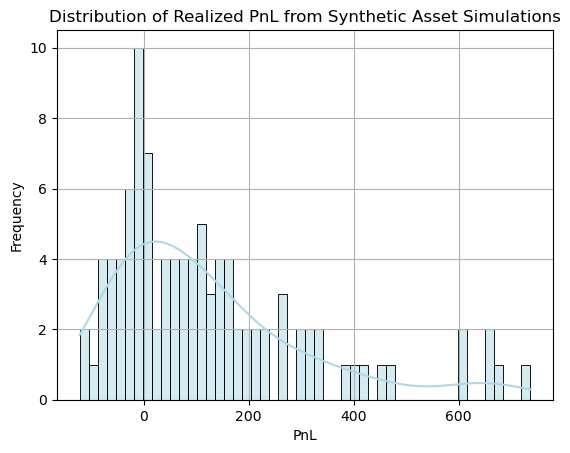

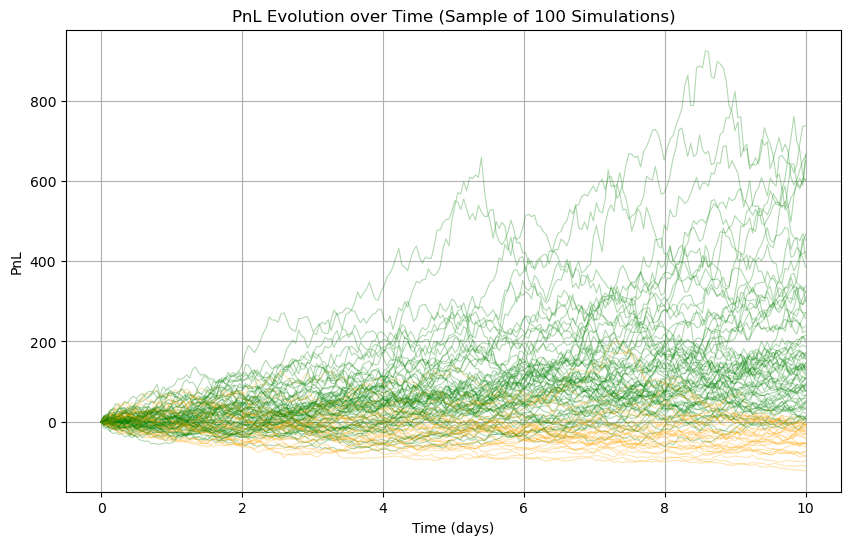

In [13]:
def batch_simulate_synthetic_assets(n_runs=1000, **kwargs):
    results = [simulate_synthetic_asset_pnl(**kwargs) for _ in range(n_runs)]

    final_pnls = np.array([r['final_pnl'] for r in results])
    liquidations = np.array([r['liquidated'] for r in results])
    no_profits = np.array([r['no_profit'] for r in results])
    max_drawdowns = np.array([r['max_drawdown'] for r in results])

    lower_bound = np.percentile(final_pnls, 5)
    upper_bound = np.percentile(final_pnls, 95)
    trimmed_pnls = final_pnls[(final_pnls >= lower_bound) & (final_pnls <= upper_bound)]
    trimmed_mean_pnl = np.mean(trimmed_pnls)
    median_pnl = np.median(final_pnls)
    mean_pnl = np.mean(final_pnls)

    print(f"Number of simulations: {n_runs}")
    print(f"Trimmed Mean PnL (5%-95%): {trimmed_mean_pnl:.2f}")
    print(f"Median PnL: {median_pnl:.2f}")
    print(f"Mean PnL: {mean_pnl:.2f}")
    print(f"Liquidation probability: {np.mean(liquidations) * 100:.1f}%")

    sns.histplot(final_pnls, kde=True, bins=50, color='lightblue')
    plt.title('Distribution of Realized PnL from Synthetic Asset Simulations')
    plt.xlabel('PnL')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for r in results[:100]:
        if r['liquidated']:
            color = 'red'
        elif r['no_profit']:
            color = 'orange'
        else:
            color = 'green'
        plt.plot(r['time_path'], r['pnl_path'], alpha=0.3, linewidth=0.8, color=color)
    plt.title('PnL Evolution over Time (Sample of 100 Simulations)')
    plt.xlabel('Time (days)')
    plt.ylabel('PnL')
    plt.grid(True)
    plt.show()

# Eseguo 100 simulazioni come test
batch_simulate_synthetic_assets(n_runs=100, T=10, dt=1/24)
